# Работа с Fits файлами
## 1) Вы уже должны найти файл. Либо ссылкой, как здесь. Либо на комп скачать и заменить LOCAL_FILE
## 2) Для корректной работы требуется 3-мерный файл. x,y (это склонение, восхождение в градусах) z, это либо длина волны, либо скорость
## 3) Двигайте ползунок и кайфуйте

interactive(children=(IntSlider(value=26, description='Channel:', max=52), Output()), _dom_classes=('widget-in…


📊 Создаем PV-диаграмму...


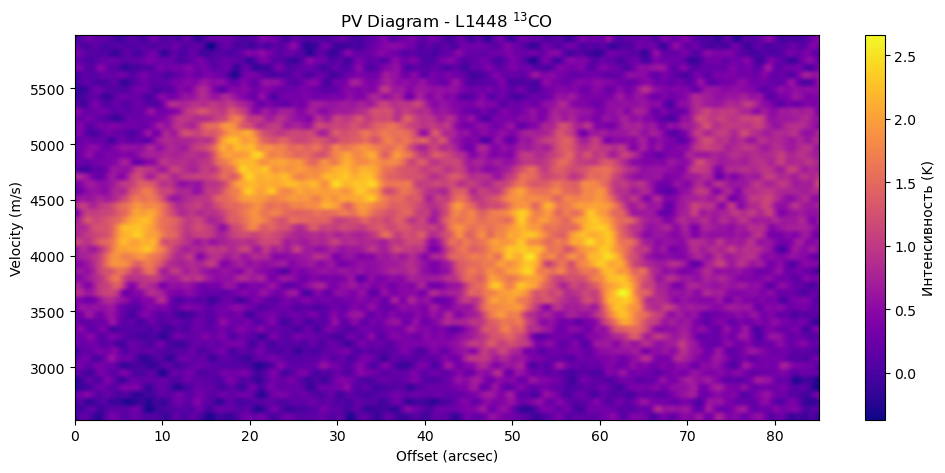

In [12]:
import os
import requests
from spectral_cube import SpectralCube
from tqdm import tqdm
import numpy as np
from astropy import units as u
from pvextractor import Path, extract_pv_slice
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from astropy.wcs import WCS

# Настройки
DATA_URL = "http://www.astropy.org/astropy-data/l1448/l1448_13co.fits"
LOCAL_FILE = "l1448_13co.fits"

def download_file():
    """Скачивание файла с проверкой"""
    if os.path.exists(LOCAL_FILE):
        return True
        
    try:
        print("🛜 Скачиваем данные...")
        response = requests.get(DATA_URL, stream=True)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        chunk_size = 8192
        
        with open(LOCAL_FILE, 'wb') as f, tqdm(
            desc=os.path.basename(LOCAL_FILE),
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                f.write(chunk)
                bar.update(len(chunk))
        return True
    except Exception as e:
        print(f"❌ Ошибка скачивания: {e}")
        return False

def create_pv_diagram(cube):
    """Создание PV-диаграммы"""
    try:
        print("\n📊 Создаем PV-диаграмму...")
        
        # Центр изображения
        ny, nx = cube.shape[1], cube.shape[2]
        center = (nx//2, ny//2)
        
        # Путь для PV-среза
        path = Path([(center[0]-30, center[1]-30), 
                   (center[0]+30, center[1]+30)])
        
        # Извлечение среза
        pv_slice = extract_pv_slice(cube, path, spacing=1*u.arcsec)
        
        # Визуализация
        plt.figure(figsize=(12, 5))
        plt.imshow(pv_slice.data, origin='lower', aspect='auto',
                  extent=[0, 85,  # Эмпирическая длина в arcsec
                         cube.spectral_axis[0].value,
                         cube.spectral_axis[-1].value],
                  cmap='plasma')
        plt.colorbar(label="Интенсивность (K)")
        plt.title("PV Diagram - L1448 $^{13}$CO")
        plt.xlabel("Offset (arcsec)")
        plt.ylabel("Velocity (m/s)")
        plt.show()
        
    except Exception as e:
        print(f"❌ Ошибка PV-диаграммы: {e}")

def interactive_viewer():
    """Интерактивный просмотр с правильными подписями"""
    try:
        # Загрузка куба
        cube = SpectralCube.read(LOCAL_FILE)
        spectral_axis = cube.spectral_axis.to(u.km/u.s)
        
        # Функция для обновления изображения
        def update(channel=len(spectral_axis)//2):
            plt.figure(figsize=(10, 8))
            ax = plt.subplot(projection=cube.wcs.celestial)
            im = ax.imshow(cube[channel].value, origin='lower', cmap='viridis',
                          vmin=np.nanpercentile(cube.filled_data[:].value, 5),
                          vmax=np.nanpercentile(cube.filled_data[:].value, 95))
            plt.colorbar(im, label="Интенсивность (K)")
            ax.set_title(f"L1448 - $^{13}$CO\nVelocity: {spectral_axis[channel]:.2f}")
            ax.set_xlabel("Right Ascension (J2000)")
            ax.set_ylabel("Declination (J2000)")
            plt.show()
        
        # Создаем интерактивный слайдер
        interact(update,
                 channel=widgets.IntSlider(
                     min=0,
                     max=len(spectral_axis)-1,
                     step=1,
                     value=len(spectral_axis)//2,
                     description='Channel:',
                     continuous_update=True
                 ))
        
        # Создаем PV-диаграмму
        create_pv_diagram(cube)
        
    except Exception as e:
        print(f"❌ Ошибка интерактивного просмотра: {e}")

# Основной процесс
if download_file():
    interactive_viewer()
else:
    print("ℹ Скачайте файл вручную и поместите в текущую директорию:")
    print(DATA_URL)

## В этой части работа с одномерными fits_ами которые получилось скачать
## fits_file имя файла который лежит в тойже папке, что и код
### получилась кривая блеска. 

Загрузка файла: tess2021204101404-s0041-0000000312070919-0212-s_lc.fits
Filename: tess2021204101404-s0041-0000000312070919-0212-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    161   19149R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 13)   int32   

Доступные столбцы данных:
ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = '

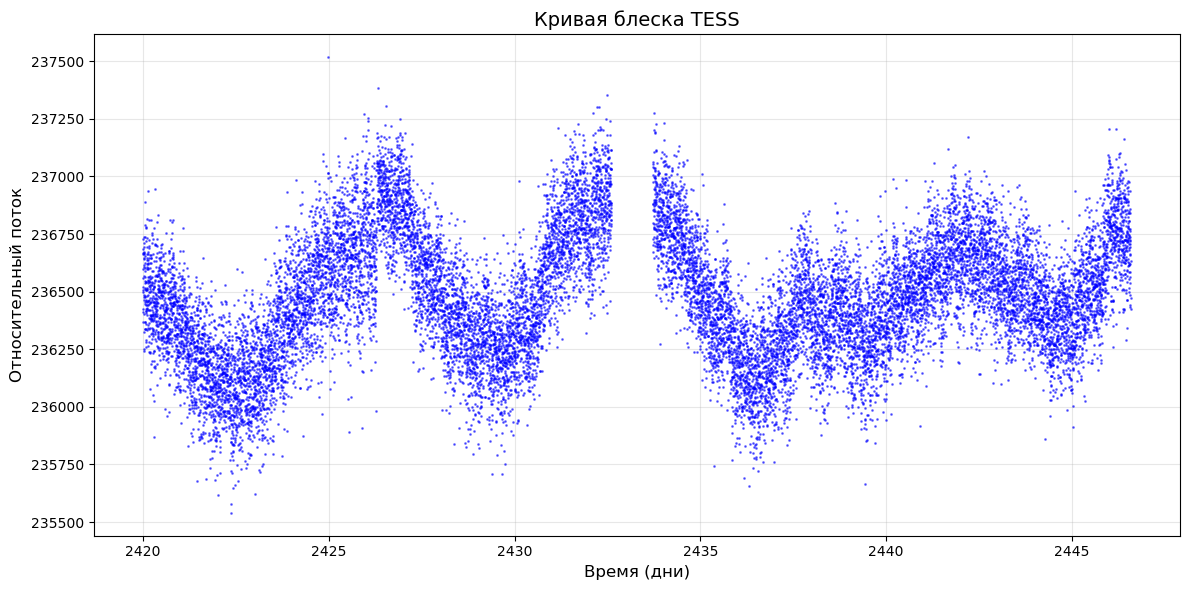

In [19]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# 1. Загрузка FITS-файла
def load_fits(file_path):
    with fits.open(file_path) as hdul:
        hdul.info()  # Выводим структуру файла
        data = hdul[1].data  # Основная таблица данных
        header = hdul[1].header  # Заголовок
    return data, header

# 2. Визуализация данных
def plot_fits_data(data):
    plt.figure(figsize=(12, 6))
    
    # Извлекаем время и поток (адаптируйте под ваши данные)
    time = data['TIME']  # Время в днях
    flux = data['PDCSAP_FLUX']  # Нормированный поток
    
    # Убираем пропущенные значения
    mask = np.isfinite(time) & np.isfinite(flux)
    time, flux = time[mask], flux[mask]
    
    # Построение графика
    plt.plot(time, flux, 'b.', markersize=2, alpha=0.5)
    plt.title('Кривая блеска TESS', fontsize=14)
    plt.xlabel('Время (дни)', fontsize=12)
    plt.ylabel('Относительный поток', fontsize=12)
    plt.grid(alpha=0.3)
    
    # Автомасштабирование с отступами
    plt.tight_layout()
    plt.show()

# 3. Основная программа
if __name__ == "__main__":
    fits_file = "tess2021204101404-s0041-0000000312070919-0212-s_lc.fits"  # Укажите ваш файл
    try:
        print(f"Загрузка файла: {fits_file}")
        data, header = load_fits(fits_file)
        
        print("\nДоступные столбцы данных:")
        print(data.columns)
        
        print("\nВизуализация...")
        plot_fits_data(data)
        
    except FileNotFoundError:
        print(f"Ошибка: файл {fits_file} не найден!")
    except Exception as e:
        print(f"Ошибка: {str(e)}")

## Попросил GPT визуализировать всю информацию из этого файла чтобы понять что вообще там есть

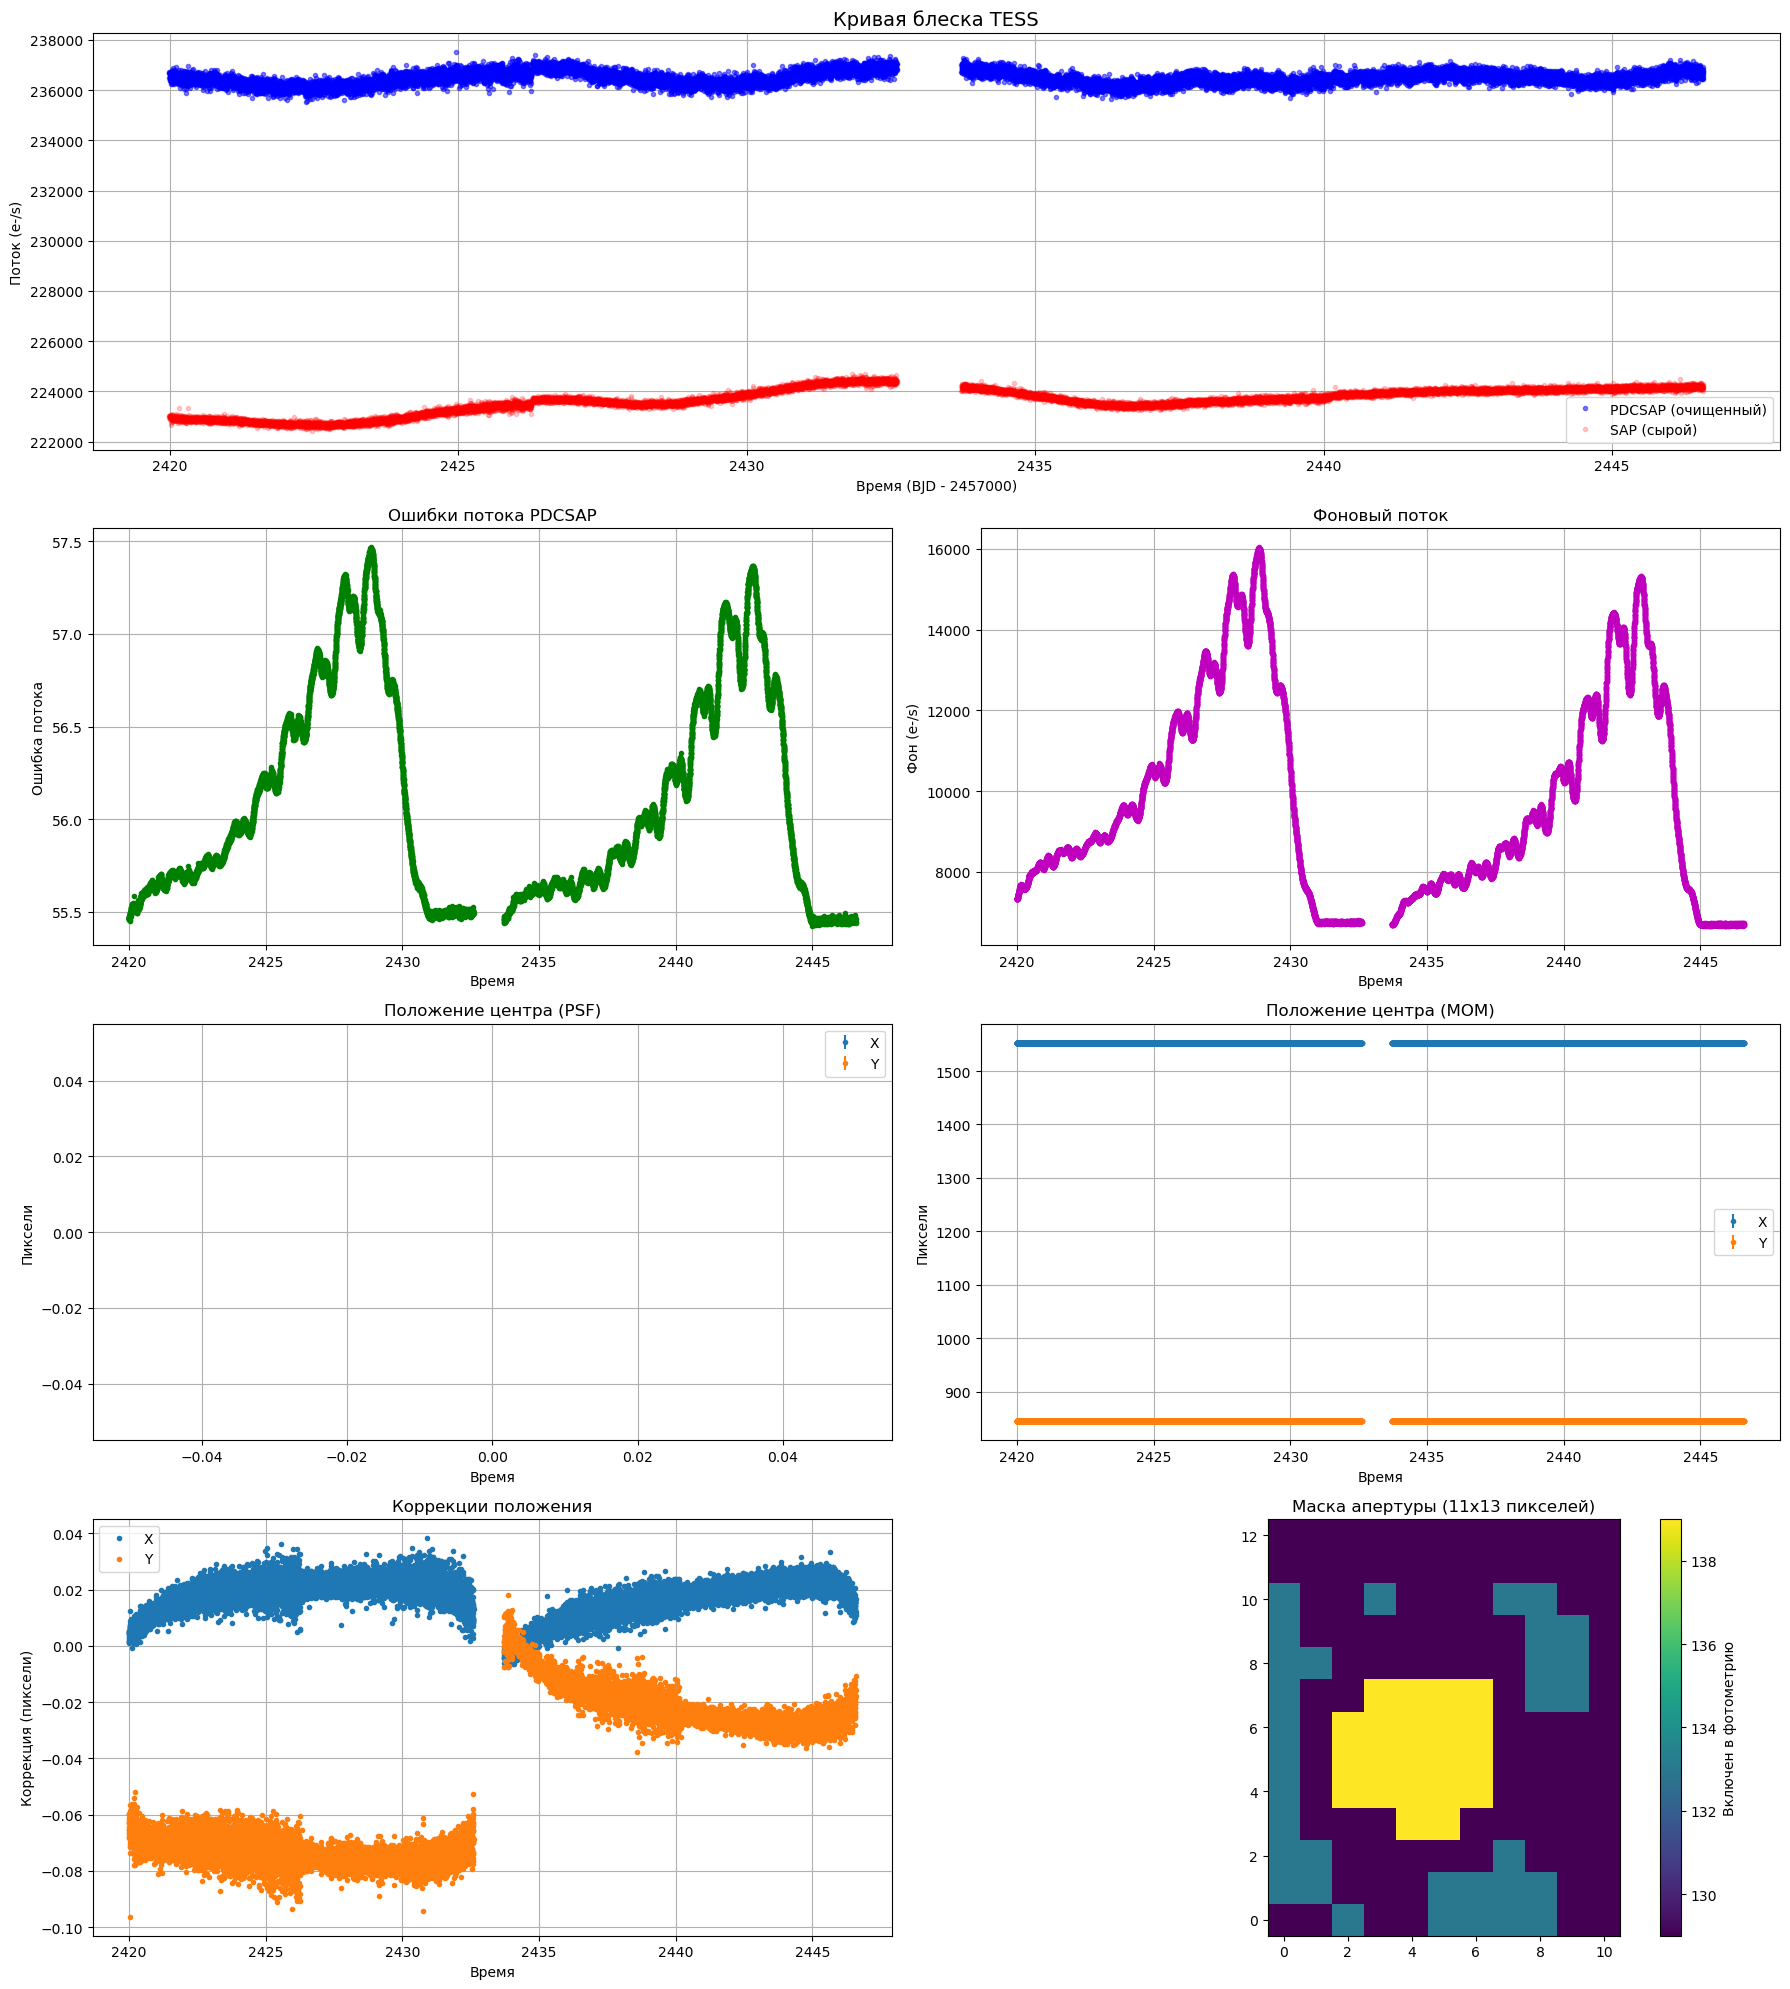

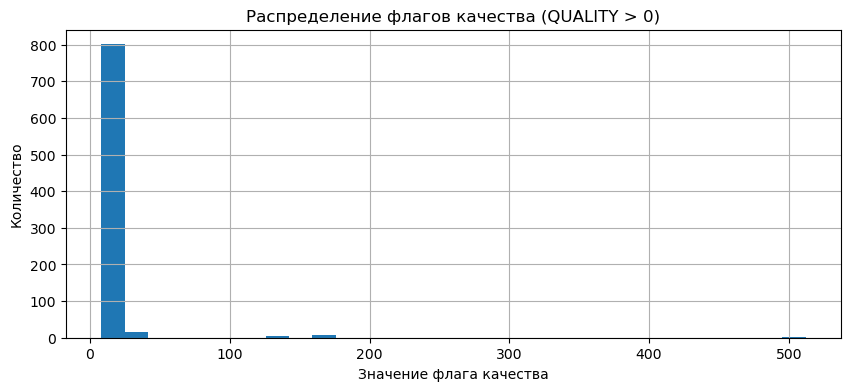

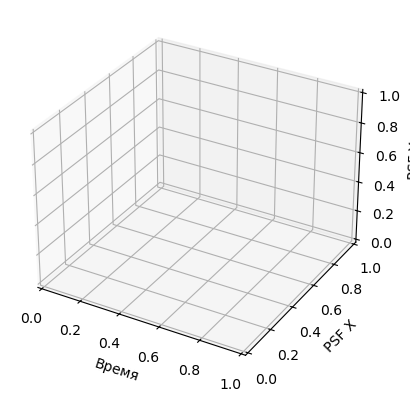

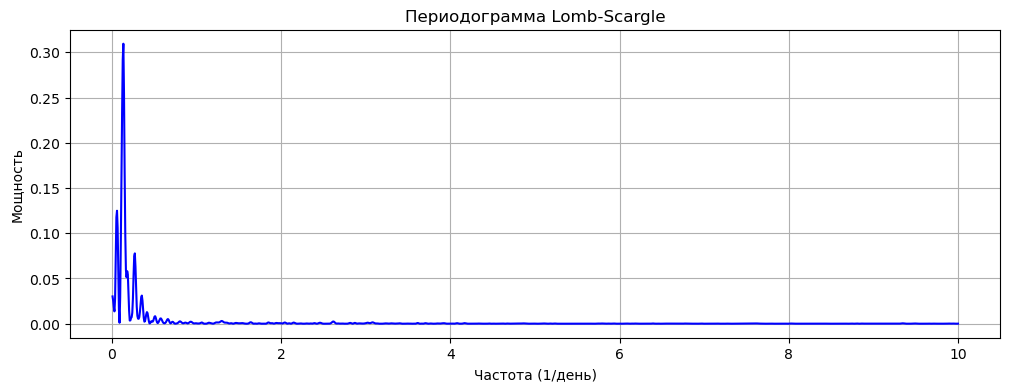

Пик 1: Частота = 0.1379 1/день, Период = 7.25 дней
Пик 2: Частота = 0.1304 1/день, Период = 7.67 дней
Пик 3: Частота = 0.1454 1/день, Период = 6.88 дней


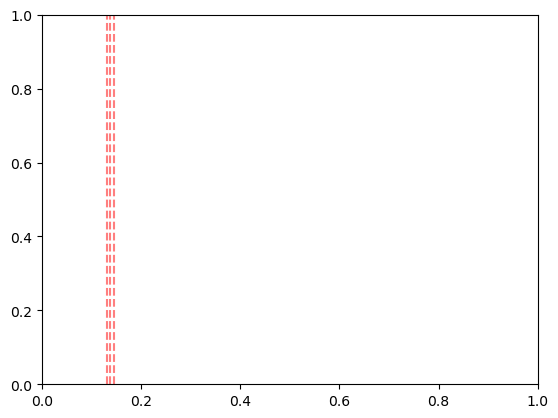

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

# Загрузка файла
file_path = "tess2021204101404-s0041-0000000312070919-0212-s_lc.fits"
with fits.open(file_path) as hdul:
    primary_hdu = hdul[0].header
    lightcurve = hdul[1].data
    aperture = hdul[2].data

# Создаем фигуру с несколькими субплoтами
plt.figure(figsize=(18, 20))
gs = GridSpec(4, 2, height_ratios=[1, 1, 1, 1])

# 1. Основная кривая блеска
ax1 = plt.subplot(gs[0, :])
ax1.plot(lightcurve['TIME'], lightcurve['PDCSAP_FLUX'], 'b.', alpha=0.5, label='PDCSAP (очищенный)')
ax1.plot(lightcurve['TIME'], lightcurve['SAP_FLUX'], 'r.', alpha=0.2, label='SAP (сырой)')
ax1.set_title('Кривая блеска TESS', fontsize=14)
ax1.set_xlabel('Время (BJD - 2457000)')
ax1.set_ylabel('Поток (e-/s)')
ax1.legend()
ax1.grid()

# 2. Ошибки измерений
ax2 = plt.subplot(gs[1, 0])
ax2.plot(lightcurve['TIME'], lightcurve['PDCSAP_FLUX_ERR'], 'g.')
ax2.set_title('Ошибки потока PDCSAP')
ax2.set_xlabel('Время')
ax2.set_ylabel('Ошибка потока')
ax2.grid()

# 3. Фоновый поток
ax3 = plt.subplot(gs[1, 1])
ax3.plot(lightcurve['TIME'], lightcurve['SAP_BKG'], 'm.')
ax3.set_title('Фоновый поток')
ax3.set_xlabel('Время')
ax3.set_ylabel('Фон (e-/s)')
ax3.grid()

# 4. Положение центра (PSF)
ax4 = plt.subplot(gs[2, 0])
ax4.errorbar(lightcurve['TIME'], lightcurve['PSF_CENTR1'], 
            yerr=lightcurve['PSF_CENTR1_ERR'], fmt='.', label='X')
ax4.errorbar(lightcurve['TIME'], lightcurve['PSF_CENTR2'], 
            yerr=lightcurve['PSF_CENTR2_ERR'], fmt='.', label='Y')
ax4.set_title('Положение центра (PSF)')
ax4.set_xlabel('Время')
ax4.set_ylabel('Пиксели')
ax4.legend()
ax4.grid()

# 5. Положение центра (MOM)
ax5 = plt.subplot(gs[2, 1])
ax5.errorbar(lightcurve['TIME'], lightcurve['MOM_CENTR1'], 
            yerr=lightcurve['MOM_CENTR1_ERR'], fmt='.', label='X')
ax5.errorbar(lightcurve['TIME'], lightcurve['MOM_CENTR2'], 
            yerr=lightcurve['MOM_CENTR2_ERR'], fmt='.', label='Y')
ax5.set_title('Положение центра (MOM)')
ax5.set_xlabel('Время')
ax5.set_ylabel('Пиксели')
ax5.legend()
ax5.grid()

# 6. Коррекции положения
ax6 = plt.subplot(gs[3, 0])
ax6.plot(lightcurve['TIME'], lightcurve['POS_CORR1'], '.', label='X')
ax6.plot(lightcurve['TIME'], lightcurve['POS_CORR2'], '.', label='Y')
ax6.set_title('Коррекции положения')
ax6.set_xlabel('Время')
ax6.set_ylabel('Коррекция (пиксели)')
ax6.legend()
ax6.grid()

# 7. Маска апертуры
ax7 = plt.subplot(gs[3, 1])
aperture_image = ax7.imshow(aperture, cmap='viridis', origin='lower')
plt.colorbar(aperture_image, ax=ax7, label='Включен в фотометрию')
ax7.set_title('Маска апертуры (11x13 пикселей)')



# Аннотируем выбранные пиксели
for y in range(aperture.shape[0]):
    for x in range(aperture.shape[1]):
        if aperture[y, x] == 1:
            ax7.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                                          fill=False, edgecolor='red', linewidth=1))

plt.tight_layout()
plt.show()

# Дополнительно: гистограмма качества данных
quality_flags = lightcurve['QUALITY']
if np.any(quality_flags > 0):
    plt.figure(figsize=(10, 4))
    plt.hist(quality_flags[quality_flags > 0], bins=30)
    plt.title('Распределение флагов качества (QUALITY > 0)')
    plt.xlabel('Значение флага качества')
    plt.ylabel('Количество')
    plt.grid()
    plt.show()


#Для 3D-визуализации положения:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lightcurve['TIME'], 
          lightcurve['PSF_CENTR1'], 
          lightcurve['PSF_CENTR2'],
          c=lightcurve['PDCSAP_FLUX'])
ax.set_xlabel('Время')
ax.set_ylabel('PSF X')
ax.set_zlabel('PSF Y')
plt.show()



#Для спектрального анализа

from astropy.timeseries import LombScargle
import numpy as np

# Предварительная обработка данных
mask = np.isfinite(lightcurve['TIME']) & np.isfinite(lightcurve['PDCSAP_FLUX'])
time = lightcurve['TIME'][mask]
flux = lightcurve['PDCSAP_FLUX'][mask]

if len(time) > 10:  # Проверка, что есть достаточное количество точек
    try:
        # Автоматический расчет частот
        ls = LombScargle(time, flux)
        freq, power = ls.autopower(minimum_frequency=0.01, maximum_frequency=10)
        
        # Визуализация
        plt.figure(figsize=(12, 4))
        plt.plot(freq, power, 'b-')
        plt.title('Периодограмма Lomb-Scargle')
        plt.xlabel('Частота (1/день)')
        plt.ylabel('Мощность')
        plt.grid()
        plt.show()
        
        # Находим 3 главных пика
        for i in range(1, 4):
            peak_freq = freq[np.argsort(power)[-i]]
            plt.axvline(peak_freq, color='r', linestyle='--', alpha=0.5)
            print(f'Пик {i}: Частота = {peak_freq:.4f} 1/день, Период = {1/peak_freq:.2f} дней')
    except Exception as e:
        print(f"Ошибка в расчете периодограммы: {str(e)}")
else:
    print("Недостаточно данных для спектрального анализа")